In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
from stable_baselines3 import PPO, DDPG, A2C, TD3, SAC
## import trajectory data
df = pd.read_csv('trajectory.csv')
df.head()
# df to numpy array
data = df.to_numpy()
data.shape
# delete the first column and the last column
trajectory = np.delete(data, 2, 1)
trajectory = np.delete(trajectory, -1, 1)
trajectory.shape

(9999, 4)

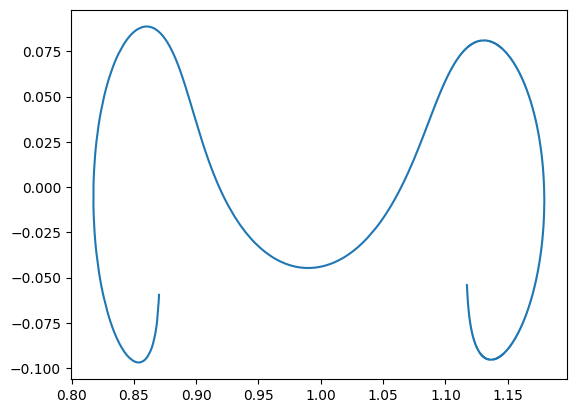

In [5]:
plt.plot(trajectory[:,0], trajectory[:,1])

In [3]:
# three body problem env

class three_body_env(gym.Env):
    def __init__(self, trajectory):
        self.trajectory = trajectory
        self.state = np.zeros(4)
        self.dt = 0.001
        self.mu = 0.012277471
        self.action_space = spaces.Box(low=-20, high=20, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(8,), dtype=np.float32)
        self.position = trajectory[0]
        self.steps = 0
        self.max_steps = 100000
        self.reward_range = (-float('inf'), float('inf'))
        self.position_arg = 0
        self.last_position_arg = 0
        self.index_counter = 0
        self.reset()

    def step(self, action):
        x = self.position[0]
        y = self.position[1]
        xdot = self.position[2]
        ydot = self.position[3]

        a_x = action[0]
        a_y = action[1]

        r1 = np.sqrt((x+self.mu)**2 + y**2)
        r2 = np.sqrt((x-1+self.mu)**2 + y**2)

        xddot = 2*ydot + x -(1-self.mu)*((x+self.mu)/(r1**3)) - self.mu*(x-1+self.mu)/(r2**3) + a_x/100
        yddot = -2*xdot + y - (1-self.mu)*(y/(r1**3)) - self.mu*(y)/(r2**3) + a_y/100

        x = x + xdot*self.dt
        y = y + ydot*self.dt

        xdot = xdot + xddot*self.dt
        ydot = ydot + yddot*self.dt

        self.position = np.array([x, y, xdot, ydot])

        # plot positon and trajectory and action
        # plt.figure(figsize=(8,8))
        # plt.plot(self.trajectory[:,0], self.trajectory[:,1])
        # plt.scatter(self.position[0], self.position[1], c='r')
        # plt.scatter(self.trajectory[self.position_arg][0], self.trajectory[self.position_arg][1], c='g')
        # plt.scatter(self.trajectory[self.last_position_arg][0], self.trajectory[self.last_position_arg][1], c='b')
        # # plot ax ay vector
        # plt.arrow(self.position[0], self.position[1], a_x/1000, a_y/1000, width=0.001, color='r')
        # plt.show()

        self.steps += 1
        # print(self.position_arg)

        # find the closest point in the trajectory
        self.position_arg = np.argmin(np.linalg.norm(self.trajectory[:, 0:2] - self.position[0:2], axis=1))
        # if the agent is not moving, give a negative reward
        distace = np.linalg.norm(self.trajectory[self.position_arg, 0:2] - self.position[0:2])
        reward = -np.exp(distace**2)
        if self.position_arg == self.last_position_arg:
            reward += -10
            # print(1)
            # plt.figure(figsize=(10,10))
            # plt.plot(self.trajectory[:,0], self.trajectory[:,1])
            # plt.scatter(self.position[0], self.position[1], c='r')
            # plt.scatter(self.trajectory[self.position_arg][0], self.trajectory[self.position_arg][1], c='g')
            # plt.scatter(self.trajectory[self.last_position_arg][0], self.trajectory[self.last_position_arg][1], c='b')
            # # plot ax ay vector
            # plt.arrow(self.position[0], self.position[1], a_x/1000, a_y/1000, width=0.001, color='r')
            # plt.show()
        elif self.position_arg > self.last_position_arg:
            # print(2)
            # reward += 100*np.exp(self.last_position_arg - self.position_arg)
            self.last_position_arg = self.position_arg
        else:
            reward += -10

        # add reward if the agent is closer to the trajectory
        # print(reward, a_x, a_y)
        # print(distace)
        # print(self.trajectory[9998, 0:2] - self.position[0:2])
        if distace > 0.01:
            reward = -1000000
            done = True
            print('haji shit dor shod')
            # print('haji shit dor shod')
            # plt.figure(figsize=(10,10))
            # plt.plot(self.trajectory[:,0], self.trajectory[:,1])
            # plt.scatter(self.position[0], self.position[1], c='r')
            # plt.scatter(self.trajectory[self.position_arg][0], self.trajectory[self.position_arg][1], c='g')
            # plt.scatter(self.trajectory[self.last_position_arg][0], self.trajectory[self.last_position_arg][1], c='b')
            # # plot ax ay vector
            # plt.arrow(self.position[0], self.position[1], a_x/1000, a_y/1000, width=0.001, color='r')
            # plt.show()
        elif np.linalg.norm(self.trajectory[9998, 0:2] - self.position[0:2]) < 0.005:
            done = True
            reward = 100000
            print('haji shit kar kard')
            # plt.figure(figsize=(8,8))
            # plt.plot(self.trajectory[:,0], self.trajectory[:,1])
            # plt.scatter(self.position[0], self.position[1], c='r')
            # plt.scatter(self.trajectory[self.position_arg][0], self.trajectory[self.position_arg][1], c='g')
            # plt.scatter(self.trajectory[self.last_position_arg][0], self.trajectory[self.last_position_arg][1], c='b')
            # # plot ax ay vector
            # plt.arrow(self.position[0], self.position[1], a_x/1000, a_y/1000, width=0.001, color='r')
            # plt.show()
        else:
            done = False

        if self.steps > self.max_steps:
            print('done')
            done = True

        observation = np.concatenate([100*self.position, -100*(self.position - self.trajectory[self.position_arg])])
        return observation, reward, done, {}

    def reset(self):
        self.steps = 0
        if np.linalg.norm(self.trajectory[9998, 0:2] - self.position[0:2]) < 0.005:
          self.position_arg = 0
          self.position = self.trajectory[0]
          self.last_position_arg = 0
        elif self.position_arg > 1000:
          self.position = self.trajectory[self.position_arg-1000]
          self.position_arg = 0
          return np.concatenate([100*self.position, -100 * (self.position - self.trajectory[self.position_arg - 999])])
        return np.concatenate([100*self.position, -100 * (self.position - self.trajectory[self.position_arg + 1])])

    def render(self, mode='human'):
        pass

    def close(self):
        pass

    def seed(self, seed=None):
        pass

In [12]:
env = three_body_env(trajectory)
# Create a TD3 agent
model = PPO('MlpPolicy', env)

/Users/Ali/Documents/BAI/Master/reinforcement-learning/.env/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
# learn model with show log
model.learn(total_timesteps=100000, reset_num_timesteps=False, tb_log_name="TD3", log_interval=10)
# save model
model.save("ppo_three_body")

In [8]:
## load model 
model = PPO.load("ppo_three_body")

/Users/Ali/Documents/BAI/Master/reinforcement-learning/.env/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/Users/Ali/Documents/BAI/Master/reinforcement-learning/.env/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


In [11]:
# test trained model
# save states
position = np.zeros((10000, 4))
env = three_body_env(trajectory)
obs = env.reset()
action_ = []
for i in range(10000):
  action, _states = model.predict(obs, deterministic=True)
  obs, rewards, dones, info = env.step(action)
  position[i] = env.position
  action_.append(action)
  env.render()
  if dones:
    obs = env.reset()

env.close()

haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit kar kard
haji shit dor shod


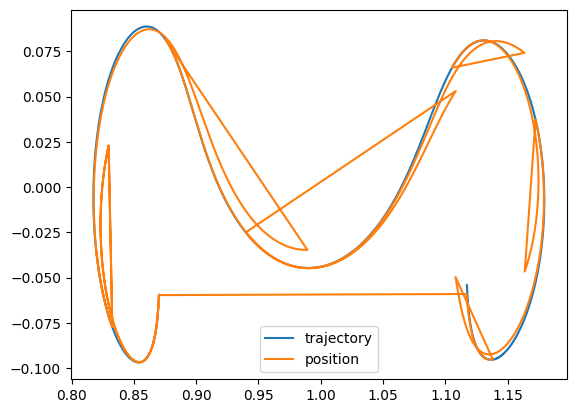

In [13]:
# plot position
plt.plot(trajectory[:,0], trajectory[:,1])
plt.plot(position[:,0], position[:,1])
plt.legend(['trajectory', 'position'])
# save figure
plt.savefig('../Figures/ppo_position.png')
plt.show()

/Users/Ali/Documents/BAI/Master/reinforcement-learning/.env/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit do

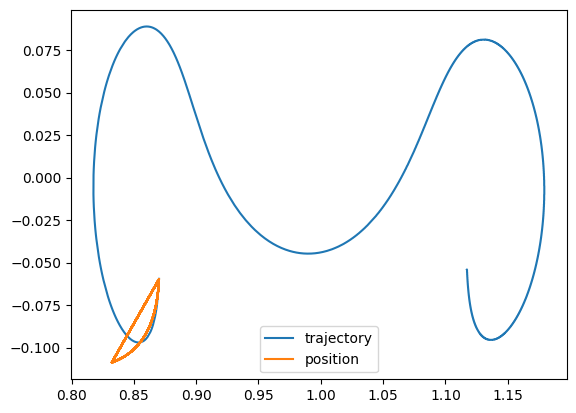

In [15]:
## load model
model = DDPG.load("ddpg_three_body")

# test trained model
# save states
position = np.zeros((10000, 4))
env = three_body_env(trajectory)
obs = env.reset()
action_ = []
for i in range(10000):
  action, _states = model.predict(obs, deterministic=True)
  obs, rewards, dones, info = env.step(action)
  position[i] = env.position
  action_.append(action)
  env.render()
  if dones:
    obs = env.reset()

env.close()

# plot position
plt.plot(trajectory[:,0], trajectory[:,1])
plt.plot(position[:,0], position[:,1])
plt.legend(['trajectory', 'position'])
# save figure
plt.savefig('../Figures/ddpg_position.png')
plt.show()


/Users/Ali/Documents/BAI/Master/reinforcement-learning/.env/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod


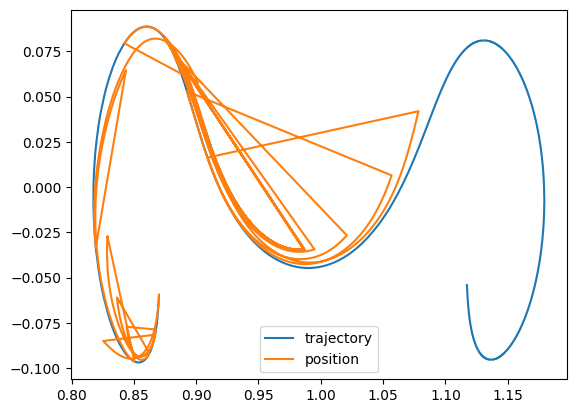

In [17]:
# load model
model = SAC.load("sac_three_body")

# test trained model
# save states
position = np.zeros((10000, 4))
env = three_body_env(trajectory)
obs = env.reset()
action_ = []
for i in range(10000):
  action, _states = model.predict(obs, deterministic=True)
  obs, rewards, dones, info = env.step(action)
  position[i] = env.position
  action_.append(action)
  env.render()
  if dones:
    obs = env.reset()

env.close()

# plot position
plt.plot(trajectory[:,0], trajectory[:,1])
plt.plot(position[:,0], position[:,1])
plt.legend(['trajectory', 'position'])
# save figure
plt.savefig('../Figures/sac_position.png')
plt.show()


/Users/Ali/Documents/BAI/Master/reinforcement-learning/.env/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit do

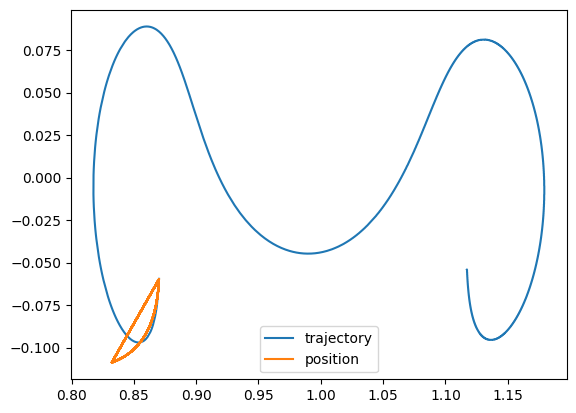

In [18]:
# load model
model = TD3.load("td3_three_body")

# test trained model
# save states
position = np.zeros((10000, 4))
env = three_body_env(trajectory)
obs = env.reset()
action_ = []
for i in range(10000):
  action, _states = model.predict(obs, deterministic=True)
  obs, rewards, dones, info = env.step(action)
  position[i] = env.position
  action_.append(action)
  env.render()
  if dones:
    obs = env.reset()

env.close()

# plot position
plt.plot(trajectory[:,0], trajectory[:,1])
plt.plot(position[:,0], position[:,1])
plt.legend(['trajectory', 'position'])
# save figure
plt.savefig('../Figures/td3_position.png')
plt.show()


/Users/Ali/Documents/BAI/Master/reinforcement-learning/.env/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod
haji shit dor shod


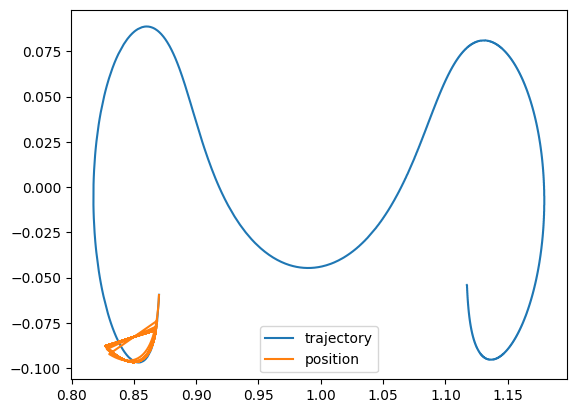

In [4]:
# load model
model = A2C.load("a2c_three_body")

# test trained model
# save states
position = np.zeros((10000, 4))
env = three_body_env(trajectory)
obs = env.reset()
action_ = []
for i in range(10000):
  action, _states = model.predict(obs, deterministic=True)
  obs, rewards, dones, info = env.step(action)
  position[i] = env.position
  action_.append(action)
  env.render()
  if dones:
    obs = env.reset()

env.close()

# plot position
plt.plot(trajectory[:,0], trajectory[:,1])
plt.plot(position[:,0], position[:,1])
plt.legend(['trajectory', 'position'])
# save figure
plt.savefig('../Figures/a2c_position.png')
plt.show()
